In [ ]:
import os 

import pysis
from pysis import isis
from pysis.exceptions import ProcessError

import knoten
from knoten import vis

import json

import ale
from ale import util
from ale.drivers.mex_drivers import MexHrscPds3NaifSpiceDriver
from ale.formatters.usgscsm_formatter import to_usgscsm

from IPython.display import Image

import plotly
plotly.offline.init_notebook_mode(connected=True)

In [2]:
# url = 'https://pds-imaging.jpl.nasa.gov/data/mro/mars_reconnaissance_orbiter/ctx/mrox_3365/data/K11_057871_1602_XN_19S163W.IMG'

# !wget -N -P data/ {url}
# fileName = 'data/' + os.path.split(url)[1]
fileName = 'data/h5270_0000_nd2.img'

In [3]:
# Set the output location of the resulting .cub
cub_loc = os.path.splitext(fileName)[0] + '.cub'

# try: 
#     isis.hrsc2isis(from_=fileName, to=cub_loc)
# except ProcessError as e:
#     print(e.stderr)

# try:
#     isis.spiceinit(from_=cub_loc, shape='ellipsoid', ckpredicted=True, spkpredicted=True)
# except ProcessError as e:
#     print(e.stderr)
    
kernels = ale.util.generate_kernels_from_cube(cub_loc, expand=True)
usgscsm_str = ale.loads(fileName, props={'kernels': kernels}, formatter="usgscsm", verbose=False)

csm_isd = os.path.splitext(fileName)[0] + '.json'
with open(csm_isd, 'w') as isd_file:
    isd_file.write(usgscsm_str)

In [4]:
usgscsm_json = json.loads(usgscsm_str)
n_lines = usgscsm_json['image_lines']
n_samples = usgscsm_json['image_samples']

In [6]:
csmisis_diff_lv_plot, csmisis_diff_ephem_plot, external_orientation_data = vis.external_orientation_diff(csm_isd, cub_loc, n_lines, n_samples, nx=10, ny=50, width=600, height=600)

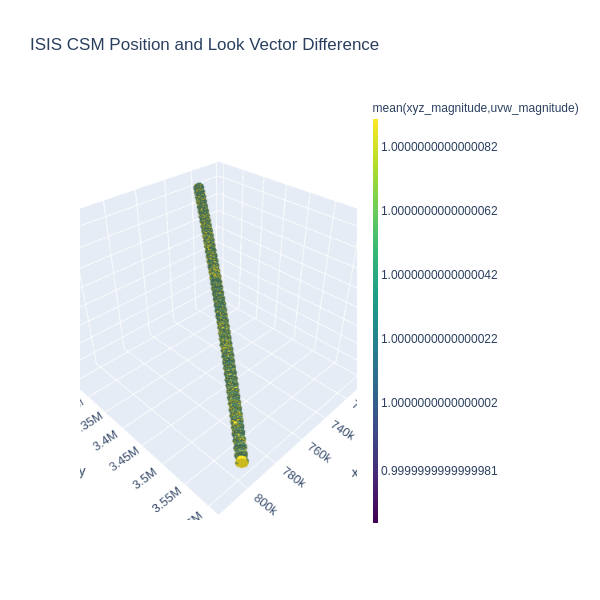

In [7]:
csmisis_diff_lv_plot_bytes = csmisis_diff_lv_plot.to_image(format="png")
csmisis_diff_ephem_plot_bytes = csmisis_diff_ephem_plot.to_image(format="png")
Image(csmisis_diff_lv_plot_bytes)

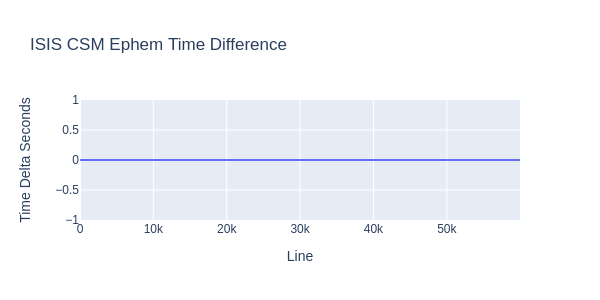

In [8]:
Image(csmisis_diff_ephem_plot_bytes)

In [9]:
external_orientation_data[['diffx', 'diffy', 'diffz', 'diffu', 'diffv', 'diffw']].describe()

,diffx,diffy,diffz,diffu,diffv,diffw
count,5.000000e+02,500.000000,500.000000,5.000000e+02,5.000000e+02,5.000000e+02
mean,3.907830e-08,0.000033,-0.000002,-1.659948e-09,-5.720113e-10,2.755067e-09
std,9.402591e-05,0.000185,0.000133,4.832424e-09,1.391811e-09,3.864359e-09
min,-1.996936e-04,-0.000361,-0.000285,-2.097117e-08,-3.793383e-09,-6.399950e-09
25%,-5.728938e-05,-0.000085,-0.000079,-3.340785e-09,-1.282760e-09,3.963496e-14
50%,3.592402e-06,0.000002,-0.000007,-7.777216e-10,-4.024210e-10,1.780418e-09
75%,6.827177e-05,0.000135,0.000109,2.321222e-10,5.923126e-11,4.897527e-09
max,1.973112e-04,0.000525,0.000290,1.079522e-08,5.374603e-09,1.105519e-08


In [10]:
isis2csm_plot, csm2isis_plot, isiscsm_plotlatlon, isiscsm_plotbf, isis2csm_data, csm2isis_data, isiscsm_latlondata, isiscsm_bfdata = vis.reprojection_diff(csm_isd, cub_loc, n_lines, n_samples, nx=10, ny=50, width=600, height=600)

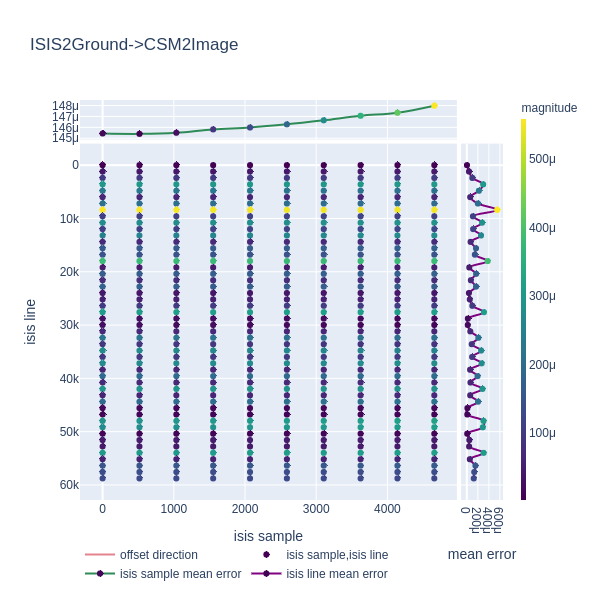

In [11]:
Image(isis2csm_plot.to_image())

In [12]:
isis2csm_data[['diff sample', 'diff line']].describe()

,diff sample,diff line
count,500.000000,5.000000e+02
mean,-0.000038,-7.512355e-05
std,0.000122,1.137411e-04
min,-0.000551,-3.189598e-04
25%,-0.000063,-1.261842e-04
50%,-0.000015,-4.461018e-05
75%,0.000010,2.722195e-07
max,0.000251,2.144139e-04


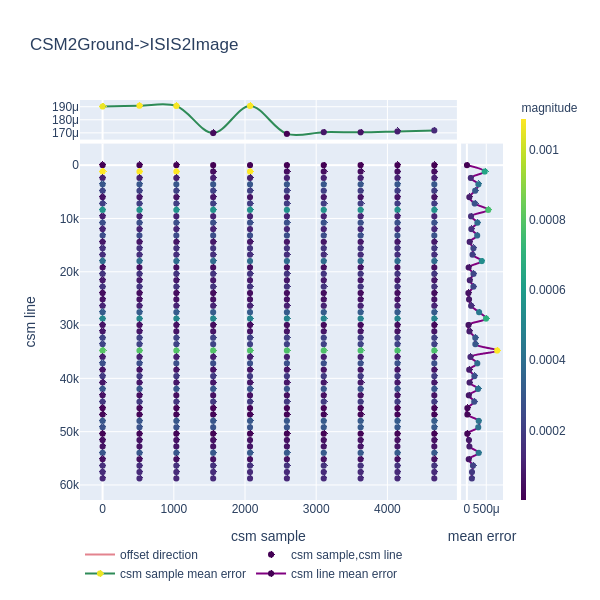

In [13]:
Image(csm2isis_plot.to_image())

In [14]:
csm2isis_data[['diff sample', 'diff line']].describe()

,diff sample,diff line
count,500.000000,500.000000
mean,0.000038,0.000072
std,0.000122,0.000199
min,-0.000251,-0.001086
25%,-0.000010,-0.000003
50%,0.000016,0.000050
75%,0.000063,0.000134
max,0.000551,0.000796


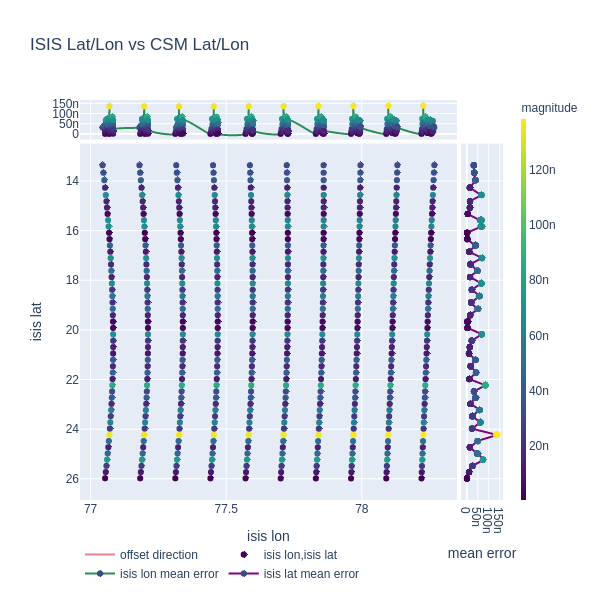

In [15]:
Image(isiscsm_plotlatlon.to_image())

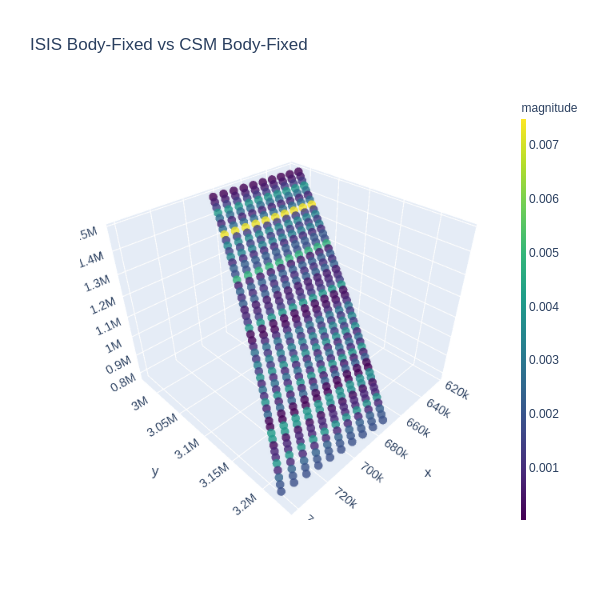

In [16]:
Image(isiscsm_plotbf.to_image())

In [17]:
isiscsm_bfdata[['diffx', 'diffy', 'diffz']].describe()

,diffx,diffy,diffz
count,500.000000,5.000000e+02,500.000000
mean,-0.692157,2.157608e-04,-0.000948
std,1.405225,4.656223e-04,0.001355
min,-3.081898,-1.222481e-03,-0.003932
25%,-1.440545,-7.036142e-07,-0.001810
50%,-1.314823,1.522501e-04,-0.000690
75%,0.942152,3.942067e-04,0.000014
max,3.041293,1.325937e-03,0.002373
